In [1]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataloaders import random_collapse_per_path, PartialMergingTaxonomyDataset
from torch.utils.data import random_split

os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

from datasets import Dataset as HFDataset
from dataloaders import dataset_to_hf_dataset, TaxonomyPreCollator, create_taxonomy_data_collator

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
import torch
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [3]:
# Adjust these paths as needed
taxonomy_matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-taxonomy-matrix.npz"
taxonomy_mapping_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/taxonomy_mapping.csv"

# Load the sparse (samples x taxonomies) matrix
X_taxonomy = sp.load_npz(taxonomy_matrix_path)
print("X_taxonomy shape:", X_taxonomy.shape)

# Load the mapping of columns -> taxonomy strings
df_tax_mapping = pd.read_csv(taxonomy_mapping_path)
taxonomy_list = df_tax_mapping["taxonomy"].tolist()

# print("Number of taxonomies:", len(taxonomy_list))
# print("First 5 taxonomies:", taxonomy_list[:5])


## dataloader
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/taxonomy_token_dictionary.pkl"
with open(output_path, "rb") as f:
    token_dict = pickle.load(f)
print("Loaded token dictionary with size:", len(token_dict))

do_augmentation=True


# Use your dynamic PyTorch dataset directly
partial_dataset = PartialMergingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    token_dict=token_dict,
    max_taxa=104,
    possible_ranks=('p','c','o','f','g','s'),
    do_augmentation=do_augmentation  # dynamic augmentation enabled
)

# Assume partial_dataset is your instance of PartialMergingTaxonomyDataset
total_samples = len(partial_dataset)
val_size = int(0.2 * total_samples)
train_size = total_samples - val_size


g = torch.Generator().manual_seed(123)
train_dataset, val_dataset = random_split(partial_dataset, [train_size, val_size], generator=g)

print(f"Total samples: {total_samples}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


X_taxonomy shape: (1836255, 8533)
Loaded token dictionary with size: 11318
Total samples: 1836255
Train samples: 1469004
Validation samples: 367251


In [4]:

# # split data 
# split_data = hf_dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)
# train_dataset = split_data["train"]
# val_dataset   = split_data["test"]


# ### i can use this to load the idex of validation samples
# val_indices = val_dataset["sample_idx"]
# print("Validation subset indices:", val_indices[:20])



# trainer

In [5]:
from pretrainer import TaxonomyPretrainer, SaveEveryNEpochsCallback
from transformers import (
    BertConfig, 
    BertForMaskedLM, 
    TrainingArguments, 
    Trainer
)
from transformers import TrainerCallback, TrainerState, TrainerControl

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:

if do_augmentation==False:
    save_model_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs/"
else:
    save_model_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/"

vocab_size = len(token_dict)  # token_dict includes <pad>, <mask>, etc.
print(vocab_size)


config = BertConfig(
    vocab_size=vocab_size,
    hidden_size=256,        # embedding dim
    num_hidden_layers=6,    # number of Transformer layers
    num_attention_heads=4,
    max_position_embeddings=128,  # or your max sequence length
    pad_token_id=token_dict["<pad>"],
)
model = BertForMaskedLM(config)

# 2) Build training arguments
training_args = TrainingArguments(
    output_dir=save_model_path,
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=256,  # 64*4,
    learning_rate=1e-4,
    logging_steps=1000,
    save_strategy="no",       #  using the callback instead
    eval_strategy="no",
)


11318


In [ ]:

# 3) data collator (the one you tested)
collator = create_taxonomy_data_collator(token_dict)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collator,
    callbacks=[SaveEveryNEpochsCallback(save_every=5, output_dir=save_model_path)]
)

# 5) Train
trainer.train()

# 6) Save final model
trainer.save_model(save_model_path)


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
1000,6.074200
2000,5.319700
3000,5.150000
4000,5.068800
5000,5.017200
6000,4.979300
7000,4.954900
8000,4.931000
9000,4.910500
10000,4.895700


[DEBUG] epoch end, state.epoch=1.0 => epoch_int=1
*** Saved checkpoint at epoch 1 to /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/checkpoint-epoch1 ***
[DEBUG] epoch end, state.epoch=2.0 => epoch_int=2
[DEBUG] epoch end, state.epoch=3.0 => epoch_int=3
[DEBUG] epoch end, state.epoch=4.0 => epoch_int=4
[DEBUG] epoch end, state.epoch=5.0 => epoch_int=5
*** Saved checkpoint at epoch 5 to /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/checkpoint-epoch5 ***
[DEBUG] epoch end, state.epoch=6.0 => epoch_int=6
[DEBUG] epoch end, state.epoch=7.0 => epoch_int=7
[DEBUG] epoch end, state.epoch=8.0 => epoch_int=8
[DEBUG] epoch end, state.epoch=9.0 => epoch_int=9
[DEBUG] epoch end, state.epoch=10.0 => epoch_int=10
*** Saved checkpoint at epoch 10 to /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epoc

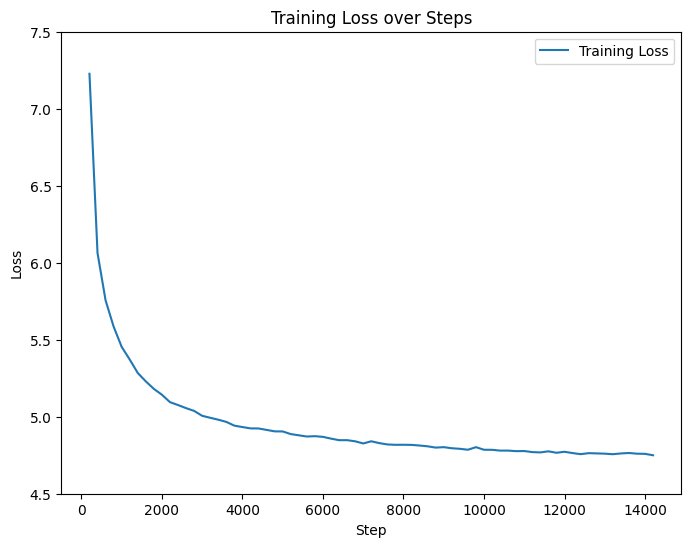

In [ ]:
# Suppose 'trainer' is your trained Trainer object
log_history = trainer.state.log_history

# Extract step/loss from training logs
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for entry in log_history:
    if "loss" in entry and "step" in entry:
        # This is a training log
        train_steps.append(entry["step"])
        train_losses.append(entry["loss"])
    elif "eval_loss" in entry and "step" in entry:
        # This is an evaluation log
        eval_steps.append(entry["step"])
        eval_losses.append(entry["eval_loss"])

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_losses, label="Training Loss")
# If you have eval logs
#plt.plot(eval_steps, eval_losses, label="Validation Loss")
plt.ylim((4.5,7.5))
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.show()


# test

In [20]:
import random
import torch
import math
import re
from transformers import BertForMaskedLM


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:


def randomly_mask_sequence(
    original_ids,
    mask_token_id,
    vocab_size,
    mlm_probability=0.15,
    mask_replace_prob=0.8,
    random_replace_prob=0.1,
    special_ids=None
):
    """
    Randomly mask ~mlm_probability fraction of NON-SPECIAL tokens in original_ids.
    Returns:
      masked_ids        : the new list of token IDs
      masked_positions  : list of indices that got masked
      original_tokens   : same length as masked_ids; only set at masked positions
    """
    if special_ids is None:
        special_ids = set()
    seq_length = len(original_ids)
    masked_ids = original_ids[:]
    masked_positions = []
    original_tokens = [None]*seq_length
    
    # 1) Decide which tokens to mask:
    # only pick positions that are not in special_ids
    candidate_positions = [
        i for i, tok in enumerate(original_ids)
        if tok not in special_ids
    ]
    # number of tokens to mask
    num_to_mask = int(len(candidate_positions) * mlm_probability)
    random.shuffle(candidate_positions)
    chosen_positions = candidate_positions[:num_to_mask]
    
    for pos in chosen_positions:
        original_tok = original_ids[pos]
        masked_positions.append(pos)
        original_tokens[pos] = original_tok  # store the ground truth at pos

        # now pick how we replace it:
        r = random.random()
        if r < mask_replace_prob:
            # replace with <mask>
            masked_ids[pos] = mask_token_id
        elif r < mask_replace_prob + random_replace_prob:
            # replace with a random ID
            rnd_id = random.randint(0, vocab_size - 1)
            masked_ids[pos] = rnd_id
        else:
            # keep original
            masked_ids[pos] = original_tok
    
    return masked_ids, masked_positions, original_tokens


def test_model_on_val_samples(
    model,
    val_dataset,
    token_dict,
    device,
    n=100,
    mlm_probability=0.15
):
    """
    Evaluate model on 'n' random samples from val_dataset.
    - We do random masking ~ mlm_probability 
    - We measure top-1 accuracy on masked positions
    Returns:
      overall_accuracy: float
      examples_list: list of dictionaries with data about each sample
    """
    model.eval()
    model.to(device)

    # Build ID->string for debugging
    id_to_str = {v: k for k, v in token_dict.items()}

    # We'll pick 'n' random samples
    indices = list(range(len(val_dataset)))
    random.shuffle(indices)
    chosen_indices = indices[:n]

    pad_id  = token_dict["<pad>"]
    mask_id = token_dict["<mask>"]
    # optionally skip other special tokens too
    special_ids = { pad_id, mask_id }  # add your <cls>, <eos> if you like

    vocab_size = len(token_dict)

    total_masked_tokens = 0
    correct_top1 = 0

    examples_list = []

    for idx in chosen_indices:
        row = val_dataset[idx]
        original_ids = row["input_ids"]

        # 1) Random mask, skipping special tokens
        masked_ids, masked_positions, original_tokens = randomly_mask_sequence(
            original_ids,
            mask_id,
            vocab_size,
            mlm_probability=mlm_probability,
            special_ids=special_ids
        )

        if len(masked_positions) == 0:
            continue

        # 2) Inference
        input_ids_tensor = torch.tensor([masked_ids], dtype=torch.long, device=device)
        attention_mask_tensor = (input_ids_tensor != pad_id).long()

        with torch.no_grad():
            outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
            logits = outputs.logits  # shape [1, seq_len, vocab_size]

        # Build an example dict
        sample_info = {
            "original_ids": original_ids,
            "masked_ids": masked_ids,
            "masked_positions": masked_positions,
            "logits": logits[0].cpu().tolist(),
            "original_tokens": original_tokens
        }

        # 3) Evaluate top-1
        for pos in masked_positions:
            true_id = original_tokens[pos]
            if true_id is None:
                continue
            total_masked_tokens += 1

            token_logits = logits[0, pos]  # shape [vocab_size]
            top1_id = torch.argmax(token_logits).item()
            if top1_id == true_id:
                correct_top1 += 1

        examples_list.append(sample_info)

    # Compute final accuracy
    if total_masked_tokens == 0:
        accuracy = 0.0
    else:
        accuracy = correct_top1 / total_masked_tokens

    return accuracy, examples_list



=== Loading checkpoint at epoch 1: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/checkpoint-epoch1 ===
Epoch 1 => Accuracy: 0.1886

=== Loading checkpoint at epoch 5: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/checkpoint-epoch5 ===
Epoch 5 => Accuracy: 0.1869

=== Loading checkpoint at epoch 10: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/checkpoint-epoch10 ===
Epoch 10 => Accuracy: 0.1969

=== Loading checkpoint at epoch 15: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/checkpoint-epoch15 ===
Epoch 15 => Accuracy: 0.1842

=== Loading checkpoint at epoch 20: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs/checkpoint-epoch20 ===
Epoch

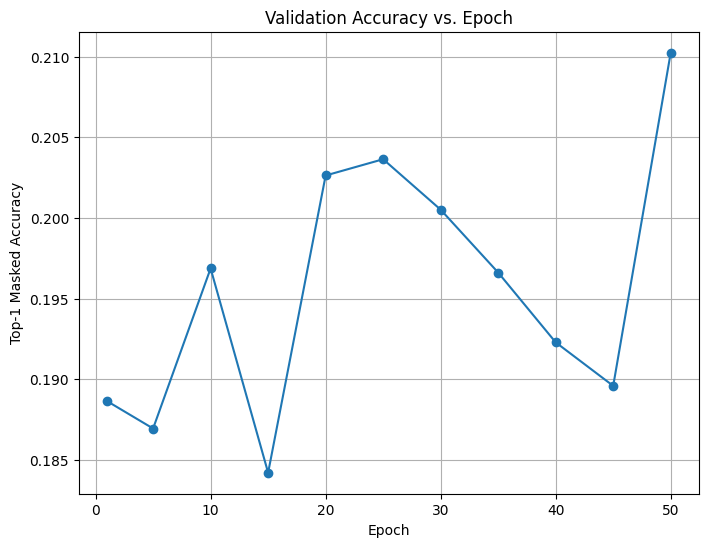

In [23]:

# Path to your model folder
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs"

# 1) Gather all checkpoint subfolders
checkpoints = []
for d in os.listdir(model_folder):
    if d.startswith("checkpoint-epoch"):
        checkpoints.append(d)

# Helper function to extract the integer epoch from the folder name, e.g. "checkpoint-epoch5" => 5
def get_epoch_from_dir(dirname):
    # find trailing digits
    match = re.search(r"(\d+)$", dirname)
    if match:
        return int(match.group(1))
    return -1

# Sort the checkpoint directories by epoch number
checkpoints.sort(key=get_epoch_from_dir)

# We'll store (epoch, accuracy)
epochs = []
accuracies = []

# 2) Evaluate each checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for d in checkpoints:
    ep = get_epoch_from_dir(d)
    checkpoint_path = os.path.join(model_folder, d)
    
    print(f"\n=== Loading checkpoint at epoch {ep}: {checkpoint_path} ===")
    
    # Load the model from that checkpoint
    model_ckpt = BertForMaskedLM.from_pretrained(checkpoint_path)
    model_ckpt.to(device)
    
    # 3) Evaluate top-1 masked accuracy on e.g. 1,000 val samples
    accuracy, _ = test_model_on_val_samples(
        model=model_ckpt,
        val_dataset=val_dataset,   # your validation dataset
        token_dict=token_dict,
        device=device,
        n=1000,                   # how many samples to test
        mlm_probability=0.15
    )
    
    epochs.append(ep)
    accuracies.append(accuracy)
    
    print(f"Epoch {ep} => Accuracy: {accuracy:.4f}")

# 4) Plot the results
plt.figure(figsize=(8,6))
plt.plot(epochs, accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Masked Accuracy")
plt.title("Validation Accuracy vs. Epoch")
plt.grid(True)

In [22]:
accuracy, examples_list = test_model_on_val_samples(
    model,
    val_dataset,
    token_dict,
    device=torch.device("cuda"),
    n=1000,
    mlm_probability=0.15
)

print("Overall top-1 masked token accuracy:", accuracy)


Overall top-1 masked token accuracy: 0.20089037284362826


In [22]:
for ex_idx, sample_info in enumerate(examples_list[:2]):
    orig_ids = sample_info["original_ids"]
    masked_ids = sample_info["masked_ids"]
    masked_positions = sample_info["masked_positions"]
    original_tokens = sample_info["original_tokens"]
    logits_matrix = sample_info["logits"]  # shape [seq_len, vocab_size]

    print(f"\n=== Example {ex_idx} ===")
    print("original_ids:", orig_ids)
    print("masked_ids:  ", masked_ids)
    print("masked_positions:", masked_positions)

    # Print the top-5 predictions for each masked position
    for pos in masked_positions[:5]:
        true_id = original_tokens[pos]
        true_str = next((k for k,v in token_dict.items() if v==true_id), "<unk>")

        # logits for this position
        token_logits = torch.tensor(logits_matrix[pos])  # shape [vocab_size]
        topk = torch.topk(token_logits, 5)
        top_indices = topk.indices.tolist()
        top_values  = topk.values.tolist()

        print(f"\nPosition {pos}, true token => {true_id} ({true_str})")
        print("Top 5 predictions:")
        for rank, (pred_id, val) in enumerate(zip(top_indices, top_values), start=1):
            pred_str = next((k for k,v in token_dict.items() if v==pred_id), "<unk>")
            print(f"  {rank}: id={pred_id}, logit={val:.2f}, => {pred_str}")



=== Example 0 ===
original_ids: [5890, 6245, 5891, 5332, 5243, 5676, 5604, 3262, 3107, 3196, 6058, 5961, 3108, 5242, 3047, 715, 9255, 6246, 5605, 6094, 1755, 6067, 8143, 6079, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
masked_ids:   [5890, 6245, 5891, 1, 1, 5676, 5604, 3262, 3107, 3196, 6058, 5961, 3108, 5242, 3047, 715, 9255, 6246, 1, 6094, 1755, 6067, 8143, 6079, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
masked_positions: [18, 4, 3]

Position 18, true token => 5605 (d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae)
Top 5 predictions:
  1: id=5243, logit=8.1